<a href="https://colab.research.google.com/github/apconzuelo/PTSCpy/blob/master/factores_de_riesgo_covid_en_m_xico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
 path = 'gdrive/My Drive/Colab Notebooks/kaggle/CoVID19MX'

In [ ]:
os.listdir('input')

['casos_confirmados.csv',
 'NACIONALIDAD.csv',
 'ORIGEN.csv',
 'TIPO_PACIENTE.csv',
 'SEXO.csv',
 'SECTOR.csv',
 'SI_NO.csv',
 'RESULTADO.csv',
 'ENTIDADES.csv',
 'covid-19_general_MX.csv',
 'covid_mx.csv']

In [ ]:
import os
import pandas as pd
import numpy as np

#os.chdir(path)
files =  os.listdir('input')
names = [name.split('.')[0].lower() for name in files]
for name, file in zip(names, files):
    globals()[name] = pd.read_csv('input/' + file)
names
general = globals()['covid-19_general_mx']

In [ ]:
general = general.replace({'SECTOR':sector.to_dict()['DESCRIPCIÓN'],
                'SEXO':{1: 'MUJER', 2:'HOMBRE', 99: 'OTRO'},
                'ENTIDAD_UM':entidades.to_dict()['ENTIDAD_FEDERATIVA'],
                'ENTIDAD_RES':entidades.to_dict()['ENTIDAD_FEDERATIVA'],
                'TIPO_PACIENTE':tipo_paciente.to_dict()['DESCRIPCIÓN'],
                'RESULTADO': {1: True, 2:False, 3:np.nan},
                'NACIONALIDAD':nacionalidad.to_dict()['DESCRIPCIÓN']})

general = general[general['RESULTADO'] == True]


In [ ]:
edad = general.EDAD
nacionalidad = general.NACIONALIDAD
for column in general.iloc[:, 9:24].columns.values.tolist():
    general.loc[:, column] = general.loc[:, column].map({1:1, 2:0,
                           97:np.nan, 98:np.nan,
                          99:np.nan})
general.EDAD = edad
general.NACIONALIDAD = nacionalidad

In [ ]:
general.loc[:, 'UCI'] = general.loc[:, 'UCI'].map({1: True, 2: False,
                               97:np.nan, 98:np.nan, 99:np.nan})

In [ ]:
general['ESTADO'] = general['FECHA_DEF'].replace({'9999-99-99': np.nan}).isna()
general.ESTADO = general.ESTADO.replace({True:'VIVO', False:'MUERTO'})
general['FECHA_DEF']= general['FECHA_DEF'].replace({'9999-99-99':np.nan})
general.FECHA_INGRESO = pd.to_datetime(general.FECHA_INGRESO)
general.FECHA_SINTOMAS = pd.to_datetime(general.FECHA_SINTOMAS)
general.FECHA_DEF = pd.to_datetime(general.FECHA_DEF)

In [ ]:
general.EDAD.head()

0    27
1    24
2    54
3    30
4    60
Name: EDAD, dtype: int64

In [ ]:
#dummy_general = pd.get_dummies(general, columns =['SEXO', 'TIPO_PACIENTE'])
#dummy_general.head()

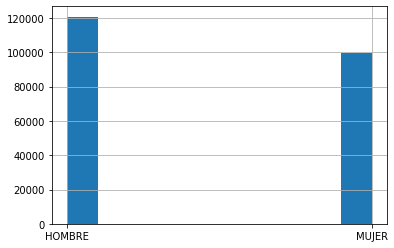

In [ ]:
import matplotlib.pyplot as plt
general['SEXO'].hist()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


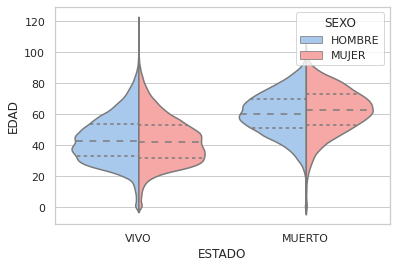

In [ ]:
import seaborn as sns

sns.set(style = 'whitegrid', palette ='pastel', color_codes = True)

ax = sns.violinplot(x = 'ESTADO', y = 'EDAD',
               hue = 'SEXO', split = True,
               inner = 'quart', data = general,
               palette = {'HOMBRE':'b', 'MUJER':'r'},
               saturation = 0.8)
#ax.set(xlabel = 'ESTATUS')

plt.show()




In [ ]:
def grupo_edad(x):
    if x <=10:
        grupo = 'INFANTE'
    elif x<=20:
        grupo = 'ADOLESCENTE'
    elif x<=30:
        grupo = 'ADULTO 20s'
    elif x<=40:
        grupo = 'ADULTO 30s'
    elif x<=50:
        grupo = 'ADULTO 40s'
    elif x<=60:
        grupo = 'ADULTO 50s'
    elif x <=70:
        grupo = 'ADULTO 60s'
    else:
        grupo = 'ANCIANO'
    return grupo

general['GRUPO'] = general.EDAD.apply(grupo_edad)

In [ ]:
grupo_edad = general.groupby(['GRUPO', 'ESTADO'])['ESTADO'].count()
total_grupo = general.groupby('GRUPO')['ESTADO'].count()
total_grupo = pd.DataFrame(total_grupo).rename(columns = {'ESTADO':'TOTAL'}).reset_index()
#sobrevivencia = grupo_edad.merge(total_grupo, on = 'GRUPO')

In [ ]:
grupo_edad = pd.DataFrame(grupo_edad).rename(columns = {'ESTADO':'CONTEO'}).reset_index()
superv_grupo = grupo_edad.merge(total_grupo, on ='GRUPO')
superv_grupo['PROPORCIONAL'] = superv_grupo.CONTEO.values/superv_grupo.TOTAL.values

In [ ]:
mortalidad = superv_grupo[superv_grupo['ESTADO'] == 'MUERTO']
supervivencia = superv_grupo[superv_grupo['ESTADO'] == 'VIVO']

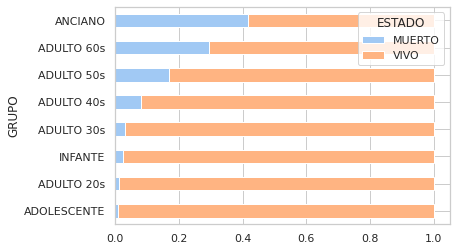

In [ ]:
superv_grupo.set_index(
    ['GRUPO', 'ESTADO']
)['PROPORCIONAL'].unstack().reset_index().sort_values('MUERTO').plot(
x = 'GRUPO', kind = 'barh', stacked = True)
plt.show()

In [ ]:
grupo_sexo = general.groupby(['GRUPO', 'SEXO', 'ESTADO'])['ESTADO'].count().unstack()
grupo_sexo['MORTALIDAD'] = grupo_sexo.MUERTO/(grupo_sexo.MUERTO+grupo_sexo.VIVO)
mortalidad_grupo_sexo = grupo_sexo['MORTALIDAD'].unstack().reset_index().sort_values('HOMBRE')
mortalidad_grupo_sexo.head()

SEXO,GRUPO,HOMBRE,MUJER
0,ADOLESCENTE,0.007429,0.010684
1,ADULTO 20s,0.015466,0.009618
7,INFANTE,0.029257,0.021703
2,ADULTO 30s,0.041278,0.019051
3,ADULTO 40s,0.106118,0.052337


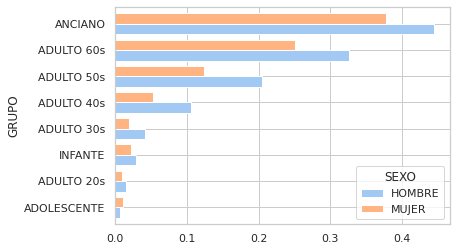

In [ ]:
mortalidad_grupo_sexo.plot(x = 'GRUPO', kind = 'barh',  width = 0.8)
plt.show()

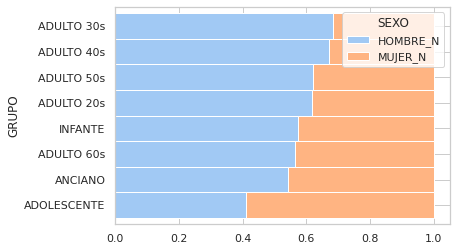

In [ ]:
mortalidad_grupo_sexo.assign(
TOTAL = lambda x: x.HOMBRE + x.MUJER, 
HOMBRE_N = lambda x: x.HOMBRE/x.TOTAL,
MUJER_N = lambda x: x.MUJER/x.TOTAL)[['GRUPO','HOMBRE_N', 'MUJER_N']].sort_values('HOMBRE_N').plot(
    x = 'GRUPO', kind = 'barh', stacked = True, width = 1)
plt.show()

In [ ]:
factores = ['ESTADO', 'GRUPO', 'SEXO', 'DIABETES', 'EPOC', 'ASMA',
              'INMUSUPR', 'CARDIOVASCULAR',
             'OBESIDAD', 'RENAL_CRONICA', 
              'TABAQUISMO', 'OTRA_CON']

factores_df = general[factores]
factores_df.index.name = 'ID'
factores_df = factores_df.replace({np.nan:False})
factores_df = factores_df.assign(SANO         = lambda x: ~x.iloc[:, 3:12].any(axis = 1))
factores_df['ANTECEDENTES'] = ~factores_df.SANO
factores_df.head()

,ESTADO,GRUPO,SEXO,DIABETES,EPOC,ASMA,INMUSUPR,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRA_CON,SANO,ANTECEDENTES
ID,,,,,,,,,,,,,,
0,VIVO,ADULTO 20s,HOMBRE,False,False,False,False,False,False,False,False,False,True,False
1,VIVO,ADULTO 20s,HOMBRE,False,False,False,False,False,False,False,False,False,True,False
2,VIVO,ADULTO 50s,MUJER,False,False,False,False,False,True,False,False,False,False,True
3,VIVO,ADULTO 20s,HOMBRE,False,False,False,False,False,False,False,False,False,True,False
4,MUERTO,ADULTO 50s,MUJER,True,False,False,False,True,False,False,False,False,False,True


In [ ]:
def filter_drop(data, column, value):
  df = data[data[column]==value].drop(columns = column)
  return df

In [ ]:
fact_df = factores_df.groupby(['GRUPO', 
                               'ESTADO', 
                               'SEXO']).agg(sum).reset_index()

In [ ]:
fact_melt = fact_df.melt(id_vars=['GRUPO', 'ESTADO', 'SEXO'],
             var_name='CONDICION', value_name='CASOS')
muertos_melt = filter_drop(fact_melt, 'ESTADO', 'MUERTO')
vivos_melt = filter_drop(fact_melt, 'ESTADO', 'VIVO')

In [ ]:
agrupaciones = ['GRUPO', 'SEXO', 'ESTADO']
sano_yn = ['SANO', 'ANTECEDENTES']
cond_list = list(['DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 
             'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA',
             'TABAQUISMO', 'OTRA_CON'])

['GRUPO', 'SEXO', 'ESTADO', 'SANO', 'ANTECEDENTES']

In [ ]:
norm_df = fact_df.groupby(['GRUPO', 'SEXO']).sum()
fact_norm =fact_df.set_index(['GRUPO', 'SEXO'])/norm_df
fact_norm = fact_norm.reset_index()
fact_norm['ESTADO'] = ['MUERTO', 'VIVO']*16
fact_norm_melt = fact_norm.melt(id_vars = ['GRUPO', 'SEXO', 'ESTADO'],
                           var_name = 'CONDICION', value_name = 'TASA')


sup_antecedentes = fact_norm_melt[fact_norm_melt['CONDICION'].isin(sano_yn)]
sup_antecedentes = filter_drop(sup_antecedentes, 'ESTADO', 'VIVO')
sup_condiciones = fact_norm_melt[fact_norm_melt['CONDICION'].isin(cond_list)]
sup_condiciones = filter_drop(sup_condiciones, 'ESTADO', 'VIVO')

In [ ]:
def mapa_cuadrado(*args, **kwargs):
    data = kwargs.pop('data')
    sortby = kwargs.pop('sortby')
    d = data.pivot(index = args[1], columns = args[0], values = args[2]
                   ).sort_values(sortby, ascending = False)
    sns.heatmap(d*100//1 -1, **kwargs)

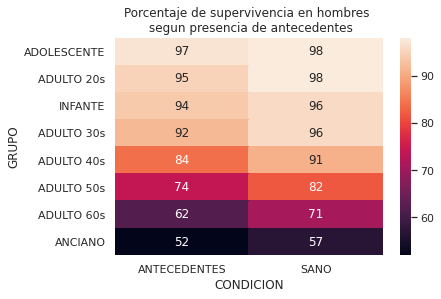

In [ ]:
sexo = 'HOMBRE'
mapa_cuadrado('CONDICION', 'GRUPO', 'TASA',
              data = filter_drop(sup_antecedentes, 'SEXO', 'HOMBRE'), 
              annot = True, sortby ='ANTECEDENTES')
plt.title('Porcentaje de supervivencia en hombres \n segun grupo y antecedentes')
plt.show()

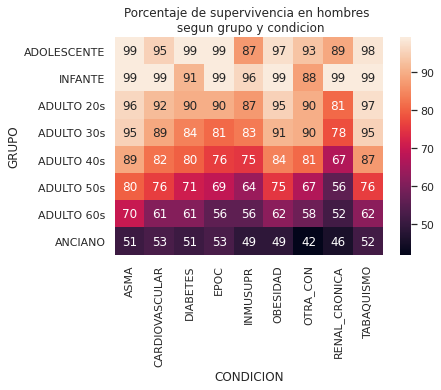

In [ ]:
mapa_cuadrado('CONDICION', 'GRUPO', 'TASA', 
              data = filter_drop(sup_condiciones, 'SEXO', 'HOMBRE'),
              annot = True, sortby = 'DIABETES')
plt.title('Porcentaje de supervivencia en hombres \n segun grupo y condicion')
plt.show()

In [ ]:
def corr_heatmap(df, method = 'pearson'):
  corr_df = df.corr(method = method)
  mask = np.zeros_like(corr_df)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(corr_df, mask = mask)

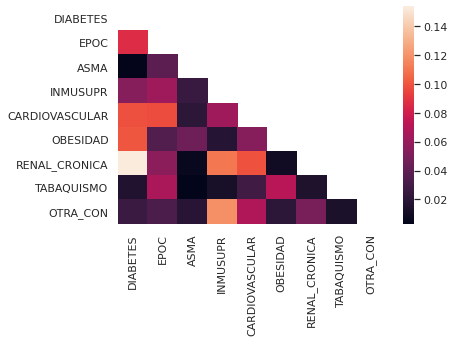

In [ ]:
predictores = general[cond_list]
corr_heatmap(predictores)

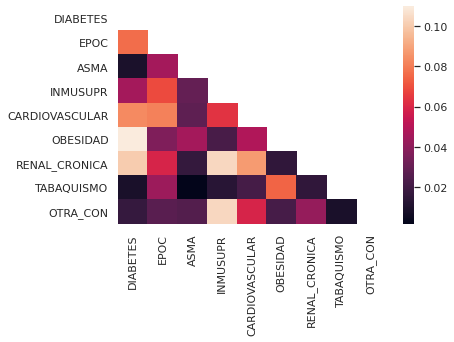

In [ ]:
pred_hosp = general[['TIPO_PACIENTE']+ cond_list]
p_hosp = filter_drop(pred_hosp, 'TIPO_PACIENTE', 'HOSPITALIZADO')
corr_heatmap(p_hosp)

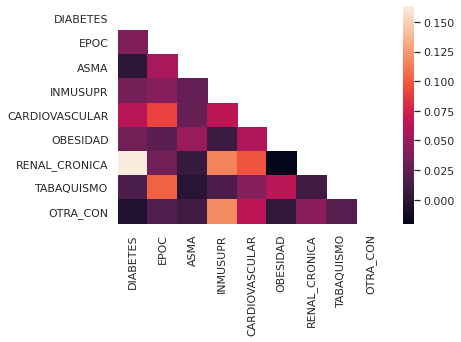

In [ ]:
pred_muerto = general[['ESTADO']+cond_list]
p_muerto = filter_drop(pred_muerto, 'ESTADO', 'MUERTO')
corr_heatmap(p_muerto)

In [470]:
!git remote add origin https://github.com/apconzuelo/Portfolio.git
!git push -u origin master

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
